# Introdução ao agrupamento DBSCAN

Existem muitas famílias de técnicas de agrupamento, no tutorial anterior nos se familiarizamos com a mais popular: K-Means (que pertence à família de agrupamento baseado em centróide). Para relembrar rapidamente, K-Means determina $k$ centróides nos dados e agrupa pontos, atribuindo-os ao centróide mais próximo.

Embora K-Means seja fácil de entender e implementar na prática, o algoritmo não cuida de valores discrepantes (outliers), portanto, todos os pontos são atribuídos a um cluster, mesmo que não pertençam a nenhum. No domínio da detecção de anomalias, isso causa problemas, pois os pontos anômalos serão atribuídos ao mesmo cluster que os pontos de dados “normais”. Os pontos anômalos puxam o centróide do cluster em sua direção, tornando mais difícil classificá-los como pontos anômalos.

Este tutorial cobrirá outro tipo de técnica de clustering conhecido como agrupamento baseado em densidade, especificamente DBSCAN (uma técnica de clustering baseada em densidade). Comparado ao agrupamento baseado em centróide, como K-Means, o agrupamento baseado em densidade funciona identificando agrupamentos “densos” de pontos, permitindo-lhe aprender agrupamentos de forma arbitrária e identificar valores discrepantes nos dados.

## O que é agrupamento baseado em densidade?

Para começar, precisamos conhecer o conceito de $\epsilon$ -vizinhança de um ponto. A $\epsilon$ -vizinhança de um ponto $p$ é definida como todos os pontos que estão a uma distância $\epsilon$ de $p$. A figura abaixo mostra a $\epsilon$ -vizinhança de um ponto $p$.

<figure>
<img src="../figures/dbscan.png" style="width:30%">
<figcaption align = "center"></figcaption>
</figure>

Agora, podemos definir o conceito de agrupamento baseado em densidade. Um cluster é definido como um conjunto de pontos que podem ser alcançados uns dos outros por uma cadeia de pontos vizinhos. A figura abaixo mostra um exemplo de agrupamento baseado em densidade.

<figure>
<img src="../figures/dbscan1.png" style="width:50%">
<figcaption align = "center"></figcaption>
</figure>


Diferentemente do K-Means, o DBSCAN não requer o número de clusters como um parâmetro predefinido. Em vez disso, ele deduz o número de clusters com base nos dados e pode identificar clusters de formas arbitrários, ao contrário do K-Means, que geralmente descobre clusters esféricos. Como mencionado anteriormente, o ɛ-vizinhança desempenha um papel crucial no DBSCAN para aproximar a densidade local. O algoritmo depende de dois parâmetros:

- **$\epsilon$ (Epsilon):** O raio das vizinhanças ao redor de um ponto de dados $p$.
- **minPts:** O número mínimo de pontos de dados necessários em uma vizinhança para definir um cluster.

O DBSCAN categoriza os pontos de dados em três categorias usando esses parâmetros:

- **Core Points:** Um ponto de dados $p$ é considerado um ponto central se a vizinhança de $\epsilon$ de $p$ (denotada como $\text{Nbhd}(p,\epsilon$)) contiver pelo menos $\text{minPts}$ pontos de dados, ou seja, $|\text{Nbhd}(p,\epsilon)| \geq \text{minPts}$.
  
- **Border Points:** Um ponto de dados $q$ é um ponto de borda se a vizinhança de $\epsilon$ de $q$ contiver menos que $\text{minPts}$ pontos de dados, mas $q$ é alcançável a partir de algum ponto central $p$.

- **Outlier:** Um ponto de dados $o$ é um outlier se não for um ponto central nem um ponto de borda. Essencialmente, isso representa a classe "outro".

Agora, vamos aprofundar em cada categoria:

- **Pontos Centrais (Core Points):**
  Pontos Centrais formam a base para clusters com base na aproximação de densidade. Ao usar o mesmo ɛ para calcular a vizinhança para cada ponto, o volume de todas as vizinhanças permanece constante. No entanto, o número de outros pontos em cada vizinhança varia. Pontos Centrais satisfazem um requisito mínimo de densidade, o que significa que eles têm uma quantidade mínima de massa em suas vizinhanças. Clusters são construídos ao redor desses pontos centrais.

- **Pontos de Borda (Border Points):**
  Pontos de Borda são pontos de dados que têm menos que $\text{minPts}$ pontos de dados em sua vizinhança de ɛ, mas são alcançáveis a partir de algum ponto central. Eles atuam como uma fronteira entre diferentes clusters.

- **Outliers:**
  Outliers são pontos de dados que não são nem pontos centrais nem pontos de borda. Essencialmente, isso representa a classe "outro".

As explicações fornecem insights sobre como o DBSCAN identifica clusters com base na densidade local e em formas, e como os parâmetros $\epsilon$ e $\text{minPts}$ influenciam a categorização dos pontos de dados.


# Implementando DBSCAN em Python

O conjunto de dados que vamos analisar é dos clientes de um distribuidor atacadista. Inclui os gastos anuais em unidades monetárias (u.m.) em diversas categorias de produtos. O banco de dado pode ser baixado [aqui](https://archive.ics.uci.edu/dataset/292/wholesale+customers).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [19]:
df = pd.read_csv("../data/wholesale+customers.zip", compression="zip")

print(df.head())

   Channel  Region  Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0        2       3  12669  9656     7561     214              2674        1338
1        2       3   7057  9810     9568    1762              3293        1776
2        2       3   6353  8808     7684    2405              3516        7844
3        1       3  13265  1196     4221    6404               507        1788
4        2       3  22615  5410     7198    3915              1777        5185


Agora, antes de prosseguir com a aplicação do DBSCAN, é muito importante que a gente conhecer os dados para entender o que estamos trabalhando e como podemos interpretar os resultados.

De acordo com a descrição fornecida no repositório oficial de aprendizado de máquina UCI deste conjunto de dados, as informações sobre os recursos do conjunto de dados são as seguintes:

- Fresh: gasto anual (m.u.) com produtos frescos (Contínuo);
- Milk: gasto anual (m.u.) com produtos lácteos (Contínuo);
- Grocery: gasto anual (m.u.)com produtos de mercearia (Contínuo);
- Frozen: gasto anual (m.u.)com produtos congelados (Contínuo)
- Detergents_Paper: gasto anual (m.u.) com detergentes e produtos de papel (Contínuo)
- Delicassen: gastos anuais (m.u.) com produtos delicatessen e delicatessen (Contínuo);
- Channel: Canal do cliente - Horeca (Hotel/Restaurante/Café) ou Canal Retail (Nominal)
- Region: Região do cliente - Lisboa, Porto ou Outro (Nominal)


Agora que você conhece os recursos do conjunto de dados, vamos exibir algumas estatísticas dos dados.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [5]:
df.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


No primeiro analise vamos excluir as colunas Channel e Region, pois não são relevantes para o nosso estudo.

In [6]:
df.drop(['Channel', 'Region'], axis=1, inplace=True)

In [7]:
df.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


## Visualizando os dados

Vamos visualizar as duas colunas `Grocery` e `Milk` para entender como os dados estão distribuídos.

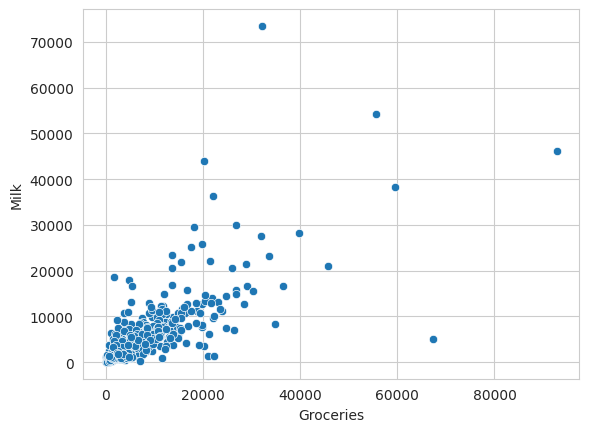

In [12]:
x = df['Grocery']
y = df['Milk']

#sns.set_style("whitegrid")
sns.scatterplot(x=x, y=y)
plt.xlabel("Groceries")
plt.ylabel("Milk")
plt.show()


A gente identificar facilmente os pontos de dados que estão muito distantes. Certo? Bem, esses são seus valores outliers.

Com o DBSCAN, queremos identificar esse grupo principal de clientes, mas também queremos sinalizar clientes com hábitos de compra anuais mais incomuns como discrepantes.

Como os valores dos dados estão na casa dos milhares, nos iremos normalizar cada atributo escalonando-o para média 0 e variação unitária. O que isso faz basicamente é ajudar a manter intactas as inter-relações entre os recursos, de modo que uma pequena mudança em um recurso se reflita no outro. **A normalização é um passo importante ao trabalhar com algoritmos de agrupamento, pois, se não for feita, os features com valores maiores dominarão aqueles com valores menores.**

In [20]:
df = df[['Grocery', 'Milk']]

scaler = StandardScaler()
df = scaler.fit_transform(df)

df = pd.DataFrame(df, columns=['Grocery', 'Milk'])

df.head()

,Grocery,Milk
0,-0.041115,0.523568
1,0.170318,0.544458
2,-0.028157,0.408538
3,-0.392977,-0.624020
4,-0.079356,-0.052396


O proximo passo é criar o modelo DBSCAN. Para isso, vamos usar a classe `DBSCAN` do módulo `sklearn.cluster`.

In [21]:
dbsc = DBSCAN(eps = .5, min_samples = 15)
dbsc.fit(df)


DBSCAN(min_samples=15)

A seguir, podemos extrair nossos rótulos de cluster e valores discrepantes para traçar nossos resultados.

In [22]:
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True


Visualmente, os outliers podem ser vistos como pontos fora do cluster

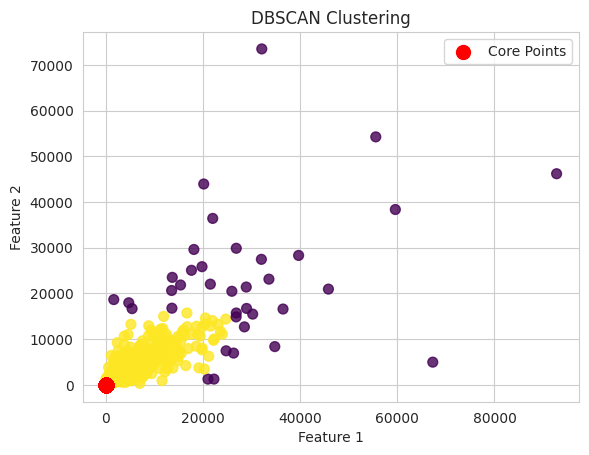

In [32]:
plt.scatter(x, y, c=labels, cmap='viridis', s=50, alpha=0.8)

plt.scatter(df.loc[core_samples, 'Grocery'], df.loc[core_samples, 'Milk'], c='red', marker='o', s=100, label='Core Points')

plt.title('DBSCAN Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

plt.show()